# **Data Challenge - Identifying Grocery Clusters**

Company XYZ is an online **grocery** store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use! This is what they asked you to do:

The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:

1) The customer who bought the most items overall in her lifetime.

2) For each item, the customer who bought that product the most.

3) Cluster items based on user co-purchase history. 

That is, create **clusters of products** that have the **highest probability of being bought together**. 

The **goal** of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

Let's start with the analysis now:

In [0]:
#importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [0]:
from google.colab import files
uploaded = files.upload()

Saving purchase_history.csv to purchase_history.csv


In [0]:
#importing purchase history dataset that contains user_ids and the ids of the products they bought

purchase_history = pd.read_csv('purchase_history.csv')

In [0]:
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [0]:
purchase_history.shape

(39474, 2)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving item_to_id.csv to item_to_id.csv


In [0]:
#importing item_to_id dataset that maps item_id to the item_name

item_to_id = pd.read_csv('item_to_id.csv')

In [0]:
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [0]:
item_to_id.shape

(48, 2)

In [0]:
purchase_history.dtypes

user_id     int64
id         object
dtype: object

In [0]:
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


Let's us first **expand** the **id** column and stack them row-wise instead of the comma separated value form so that each row has the data of 1 (user, product).

In [0]:
purchase_history = purchase_history.set_index(purchase_history.columns.drop('id',1).tolist()).id.str.split(',', expand = True).stack().reset_index().rename(columns={0:'id'}).loc[:, b.columns]

In [0]:
purchase_history.columns = ['user_id', 'item_id']
purchase_history['item_id'] = purchase_history['item_id'].astype('int')
purchase_history.head()

,user_id,item_id
0,222087,27
1,222087,26
2,1343649,6
3,1343649,47
4,1343649,17


In [0]:
#renaming column names 

item_to_id.columns = ['item_name', 'item_id']
item_to_id.head()

,item_name,item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


Now, we are in a position to **merge** both the datasets and perform our analysis.

In [0]:
users_items = purchase_history.merge(item_to_id, on = 'item_id')

In [0]:
users_items.head()

,user_id,item_id,item_name
0,222087,27,dishwashing
1,404134,27,dishwashing
2,987613,27,dishwashing
3,60201,27,dishwashing
4,1166671,27,dishwashing


In [0]:
users_items.shape

(319995, 3)

In [0]:
#top 10 items bought

top_items = pd.DataFrame(users_items.item_name.value_counts()[0:10])
top_items = top_items.reset_index()
top_items.columns = ['item_name', 'item_count']
top_items = top_items.sort_values(by = 'item_count', ascending=True)
top_items

,item_name,item_count
9,berries,8878
8,cauliflower,8902
7,bananas,8921
6,grapefruit,8951
5,broccoli,8980
4,apples,9008
3,cherries,9019
2,cucumbers,9050
1,sugar,9119
0,lettuce,14473


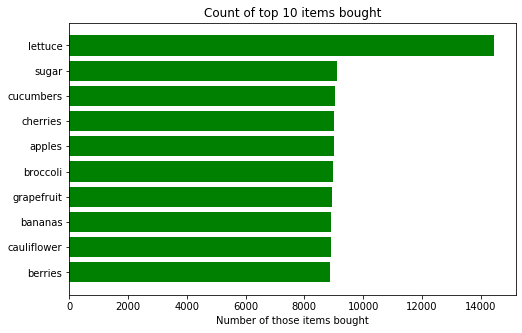

In [0]:
#visualizing top 10 items bought by all the users combined

plt.figure(figsize=(8, 5))
plt.title('Count of top 10 items bought')
plt.barh(range(0,10), top_items['item_count'][0:10], color='green', align='center')
plt.yticks(range(0,10), [i for i in top_items.item_name[0:10]])
plt.xlabel('Number of those items bought')
plt.show()

In [0]:
#top 10 users based on the number of products they bought

top_users = pd.DataFrame(users_items.user_id.value_counts()[0:10])
top_users = top_users.reset_index()
top_users.columns = ['user_id', 'items_bought']
top_users = top_users.sort_values(by = 'items_bought')
top_users

,user_id,items_bought
9,828721,58
7,718218,60
8,653800,60
5,917199,62
6,1485538,62
4,377284,63
2,599172,64
3,397623,64
1,367872,70
0,269335,72


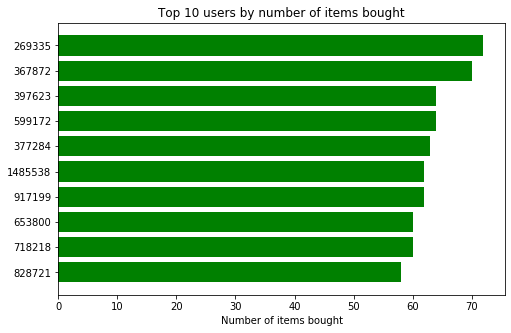

In [0]:
#visualizing the top 10 users based on the number of products they bought

plt.figure(figsize=(8, 5))
plt.title('Top 10 users by number of items bought')
plt.barh(range(0,10), top_users['items_bought'][0:10], color='green', align='center')
plt.yticks(range(0,10), [i for i in top_users.user_id[0:10]])
plt.xlabel('Number of items bought')
plt.show()

In [0]:
users_items

,user_id,item_id,item_name
0,222087,27,dishwashing
1,404134,27,dishwashing
2,987613,27,dishwashing
3,60201,27,dishwashing
4,1166671,27,dishwashing
...,...,...,...
319990,1478925,4,baby items
319991,1317912,4,baby items
319992,776603,4,baby items
319993,1373317,4,baby items


In [0]:
top_10_customers_by_number_of_purchases = users_items.user_id.value_counts()[0:10]
top_10_customers_by_number_of_purchases

269335     72
367872     70
599172     64
397623     64
377284     63
917199     62
1485538    62
718218     60
653800     60
828721     58
Name: user_id, dtype: int64

In [0]:
list_items = list(users_items.item_id.unique())

Now, for each item, we need to find the customer who bought that item the most.

In [0]:
# dataframe that contains highest cpount of each product by a particular customer

df = pd.DataFrame({'item_id' : np.nan, 'user_id' : np.nan, 'item_highest_count' : np.nan}, index = range(0,48))

In [0]:
i = 0
for j in list_items:
  df1 = users_items[users_items['item_id']==j].user_id.value_counts().reset_index()
  df1.columns = ['user_id', 'item_count']
  df.iloc[i,0] = j
  df.iloc[i,1] = df1.iloc[0,0]
  df.iloc[i,2] = df1.iloc[0,1]
  i = i + 1

In [0]:
df['item_id'] = df['item_id'].astype('int')
df['user_id'] = df['user_id'].astype('int')
df['item_highest_count'] = df['item_highest_count'].astype('int')

In [0]:
df

,item_id,user_id,item_highest_count
0,27,956666,4
1,26,1341188,4
2,6,334664,4
3,47,1374100,4
4,17,366155,4
5,18,917199,5
6,12,791038,3
7,23,920002,5
8,22,1199670,4
9,43,996380,4


In [0]:
item_to_id.head()

,item_name,item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [0]:
a = pd.merge(df, item_to_id,on='item_id')

In [0]:
a

,item_id,user_id,item_highest_count,item_name
0,27,956666,4,dishwashing
1,26,1341188,4,spaghetti sauce
2,6,334664,4,poultry
3,47,1374100,4,pork
4,17,366155,4,beef
5,18,917199,5,laundry detergent
6,12,791038,3,shampoo
7,23,920002,5,tea
8,22,1199670,4,frozen vegetables
9,43,996380,4,coffee


In [0]:
users_items.head()

,user_id,item_id,item_name
0,222087,27,dishwashing
1,404134,27,dishwashing
2,987613,27,dishwashing
3,60201,27,dishwashing
4,1166671,27,dishwashing


In [0]:
users_items = users_items.drop(columns = ['item_name'])
users_items = users_items.reset_index()


In [0]:
users_items.head()

,index,user_id,item_id
0,0,222087,27
1,1,404134,27
2,2,987613,27
3,3,60201,27
4,4,1166671,27


Now, let us build a **item to user matrix** so that we can start our analysis of the best **cluster of products**. To get the matrix, we first create a column 'count' that counts the number of each unique (user,item).

In [0]:
users_items = users_items.groupby(['user_id', 'item_id']).index.count().reset_index()
users_items.columns = ['user_id', 'item_id', 'count']

In [0]:
users_items

,user_id,item_id,count
0,47,2,1
1,47,3,1
2,47,4,1
3,47,13,1
4,47,15,1
...,...,...,...
290553,1499974,25,1
290554,1499974,31,1
290555,1499974,34,1
290556,1499974,37,1


In [0]:
#using pivot to create a matrix

user_item_count_matrix = users_items.pivot(index='item_id', columns='user_id', values = 'count')

In [0]:
user_item_count_matrix.shape

(48, 24885)

In [0]:
user_item_count_matrix = pd.DataFrame(user_item_count_matrix)

user_id,47,68,113,123,223,281,323,394,420,453,527,553,556,609,613,621,713,770,950,956,960,990,1075,1233,1260,1304,1312,1315,1379,1383,1444,1520,1578,1769,1789,1814,1833,1835,1849,2007,...,1498302,1498311,1498313,1498357,1498364,1498450,1498510,1498581,1498600,1498638,1498718,1498738,1498776,1498783,1498785,1498791,1498838,1498875,1498921,1498930,1498969,1499075,1499086,1499087,1499125,1499200,1499261,1499428,1499456,1499461,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,1.0,1.0,NaN,1.0,1.0,2.0,1.0,2.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,2.0,NaN
3,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,2.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,...,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0
9,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN


In [0]:
#imputing null values with 0

user_item_count_matrix = user_item_count_matrix.fillna(0)

In [0]:
user_item_count_matrix

user_id,47,68,113,123,223,281,323,394,420,453,527,553,556,609,613,621,713,770,950,956,960,990,1075,1233,1260,1304,1312,1315,1379,1383,1444,1520,1578,1769,1789,1814,1833,1835,1849,2007,...,1498302,1498311,1498313,1498357,1498364,1498450,1498510,1498581,1498600,1498638,1498718,1498738,1498776,1498783,1498785,1498791,1498838,1498875,1498921,1498930,1498969,1499075,1499086,1499087,1499125,1499200,1499261,1499428,1499456,1499461,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Now, to find the similarity in products, we will use **cosine similarity**.

In [0]:
similarity_matrix = cosine_similarity(user_item_count_matrix, user_item_count_matrix)

In [0]:
similarity_matrix

array([[1.        , 0.50689509, 0.42014547, ..., 0.39499794, 0.39216409,
        0.32822116],
       [0.50689509, 1.        , 0.46687405, ..., 0.46240735, 0.46025666,
        0.38007738],
       [0.42014547, 0.46687405, 1.        , ..., 0.35493295, 0.35183204,
        0.29797175],
       ...,
       [0.39499794, 0.46240735, 0.35493295, ..., 1.        , 0.38592036,
        0.31812841],
       [0.39216409, 0.46025666, 0.35183204, ..., 0.38592036, 1.        ,
        0.31103165],
       [0.32822116, 0.38007738, 0.29797175, ..., 0.31812841, 0.31103165,
        1.        ]])

In [0]:
item_item_similarity = similarity_matrix.copy()

Lets use **PCA** which just because it will help us later on to visualize the clusters on 2 dimentions.

In [0]:
pca = PCA()
# rotate by PCA, making it easier to be visualized later
items_rotated = pca.fit_transform(item_item_similarity)

In [0]:
items_rotated

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.355639,-0.025103,-0.051129,-0.039214,-0.049529,0.003300,0.019830,-0.011458,0.084798,-0.042284,-0.034813,-0.050485,-0.041422,-0.019240,0.036545,0.023968,0.001263,-0.036898,-0.007538,0.036723,0.093759,0.309028,0.013161,0.024407,-0.002661,-0.009508,-0.090150,-0.109684,0.121218,-0.087961,0.401675,-0.029754,0.010955,-0.040705,-0.018638,0.014156,0.005833,0.000455,-0.019760,-0.012837,-0.006332,-0.022289,-0.002654,-0.001332,0.011263,-0.026911,-0.129284,5.732095e-17
2,0.793894,-0.041103,0.013244,-0.009035,-0.141627,-0.036540,-0.114816,-0.087070,0.000959,-0.035030,0.002478,-0.014695,-0.033023,0.003010,0.000027,0.021939,-0.007611,-0.018091,-0.020279,0.011894,0.017841,0.105947,-0.008328,-0.002832,0.005282,-0.005034,-0.010756,-0.008286,0.019454,-0.024754,0.083169,0.011303,-0.014496,-0.018227,-0.027896,0.000797,0.008811,0.018309,-0.039028,-0.015895,-0.027280,0.017406,0.013680,0.004437,-0.030161,0.006713,0.379136,5.732095e-17
3,0.135668,-0.029584,-0.028246,-0.012556,-0.013317,0.004220,-0.020503,-0.050246,0.177599,-0.080864,-0.006532,-0.034642,-0.051377,-0.064848,0.028531,0.062893,-0.030856,-0.045802,-0.011693,0.063812,0.110782,0.493380,-0.058889,0.079477,-0.009275,0.010338,0.047297,0.026605,-0.077784,0.098903,-0.291785,0.005449,-0.011095,0.043220,0.035794,-0.015220,0.010569,0.002939,0.020455,-0.007168,0.040652,0.004387,0.029288,0.000224,0.009908,0.001288,-0.035429,5.732095e-17
4,-0.532034,0.020259,-0.022628,-0.037650,0.022756,-0.046219,0.042124,-0.132828,0.651482,-0.274771,-0.107984,-0.202834,-0.075828,-0.166487,-0.065732,-0.027029,-0.060635,-0.019070,0.066064,-0.063140,-0.114698,-0.160571,0.011597,-0.041686,0.016343,0.006321,-0.007495,-0.008856,0.026418,-0.007505,0.009914,0.010167,0.010641,-0.015209,-0.020925,0.012169,-0.006905,0.013531,0.000133,0.002444,0.005894,-0.003617,-0.005383,0.001555,-0.006114,0.007527,0.020217,5.732095e-17
5,-0.678770,-0.093874,-0.347623,-0.232866,-0.090366,-0.057124,-0.018074,0.038866,-0.048059,-0.014378,0.043577,-0.069655,0.025629,-0.057747,0.577510,-0.105189,0.073962,0.243050,-0.074466,-0.140567,0.020414,-0.012271,-0.031869,0.032216,0.004298,0.015558,0.000439,-0.012772,-0.009521,0.010764,0.000008,0.007047,-0.005452,-0.003056,-0.001901,-0.003918,0.001011,0.010725,-0.008466,0.011890,0.002598,0.007605,0.009321,-0.003278,0.006540,0.000677,0.023603,5.732095e-17
6,0.312811,-0.036128,0.044851,0.017309,-0.035048,0.080819,-0.047894,-0.021530,0.119243,0.409097,0.070773,-0.106091,0.037369,-0.049597,0.012068,-0.015435,0.009575,0.024370,-0.013180,0.030000,-0.005160,-0.018279,0.013340,0.014269,-0.004145,0.016129,0.038107,0.040490,0.006305,0.043271,-0.004505,-0.018967,0.068800,-0.030304,-0.138994,0.036768,-0.170334,0.130051,-0.020227,0.037458,-0.003532,-0.068856,0.111363,0.038920,-0.179474,0.195229,-0.039911,5.732095e-17
7,-0.550273,-0.188354,0.058120,0.381101,-0.032518,-0.001882,-0.036626,-0.035533,-0.078704,0.033615,0.018785,-0.132469,0.001443,0.137641,0.186357,-0.147836,-0.212369,-0.314327,0.386071,-0.016714,0.203766,-0.046801,-0.000802,0.024728,-0.012901,0.049127,0.009160,-0.004796,0.002312,-0.005545,0.006514,0.004319,-0.004025,0.012982,0.011108,0.000922,0.004137,0.002563,-0.003264,0.000230,-0.004935,0.009531,0.007640,0.003959,0.010467,0.000722,0.013446,5.732095e-17
8,-0.052373,0.402611,-0.084719,0.101044,0.061785,0.033619,-0.072494,-0.017836,-0.039679,0.006366,0.030911,-0.011568,0.045638,0.027841,0.007456,-0.006757,0.034465,0.020870,0.041472,0.063016,0.031045,0.005409,-0.127503,-0.138559,0.521435,-0.008018,-0.004659,-0.077046,0.047287,-0.017102,-0.033347,0.023296,0.017018,0.021030,-0.011996,0.001499,-0.017128,0.013325,0.005499,-0.024467,-0.008533,-0.014347,0.004348,-0.003086,0.009040,-0.013534,-0.003083,5.732095e-17
9,0.337225,-0.08890

In [0]:
#items rotated contains the same information as item_item_similarity just that the previous variables have been shifted using PCA components

items_rotated = pd.DataFrame(items_rotated, index=user_item_count_matrix.index, columns=["pc{}".format(index+1) for index in range(0,item_to_id.shape[0])])


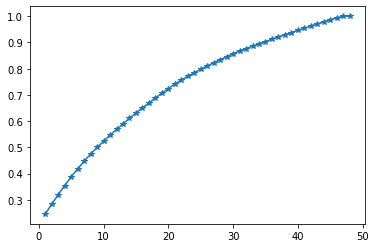

In [0]:
# show the total variance which can be explained by first K principle components
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")

We will use **K-means clustering** to cluster the products and to find the right number of clusters we will try both **silhouette** **score** method and **elbow** **method** and then manually decide.

In [0]:
item_to_id.index = item_to_id.item_id
item_to_id = item_to_id.drop(columns = ['item_id'])

In [0]:
#function to plot clusters using pc1 and pc2 pca components on 2D

def show_clusters(items_rotated,labels):
   
    #plot and print clustering result
    fig = plt.figure(figsize=(15, 10))

    #endless cycle iterator
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])
    print('Labels are :', end = ' ')
    print(labels)
    grps = items_rotated.groupby(labels)
    i = 1
    for label,grp in grps:
      plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)
      print('Cluster:', end = ' ')
      print(i)
      i = i+1
      print('\n')
      names = item_to_id.loc[grp.index,"item_name"]
      for index, name in enumerate(names):
        print(index+1,name)
      print('\n')  

     #annotate
    for itemid in items_rotated.index:
      x = items_rotated.loc[itemid,"pc1"]
      y = items_rotated.loc[itemid,"pc2"]
      name = item_to_id.loc[itemid,"item_name"]
      name = re.sub('\W', ' ', name)
      plt.text(x,y,name)
      plt.tight_layout()

      plt.legend(loc="best")

In [0]:
#function that takes in number of clusters and calls the plot function to plot the clusters

def cluster(n_clusters,n_components=48):
  
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(items_rotated.values[:, :])
   
    # display results on a plot
    show_clusters(items_rotated, kmeans.labels_)

In [0]:
#using K emans for different number of clusters and trying to find the right number of clusters

#chose number of clusters
inertias = []
silhouettes = []
#check the number of clusters between 2 and 25 ( won't take into consideration more than that)
k_clusters = range(2,25)
for k in k_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_rotated)
    inertias.append(kmeans.inertia_)  #append intertia scores
    silhouettes.append(silhouette_score(items_rotated, kmeans.predict(items_rotated)))  #append silhouette scores


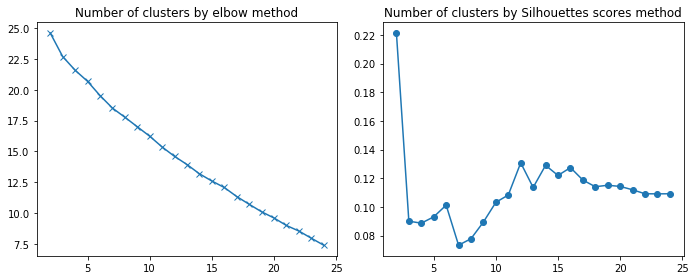

In [0]:
#to use elbow
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.title('Number of clusters by elbow method')
plt.plot(k_clusters,inertias,marker='x')# want to use elbow method to find best k

#to use silhouettes 
fig.add_subplot(1,2,2)
plt.title('Number of clusters by Silhouettes scores method')
plt.plot(k_clusters,silhouettes,marker='o')# the higher the better
plt.tight_layout()

The **silhouettes** score method tells us that any ideal number of clusters would lie around 15. But since we just have 48 products, let as take 10 clusters and plot the products that belong to different clusters.

Labels are : [6 9 6 2 5 8 2 3 0 9 5 1 6 3 2 3 8 7 1 4 3 6 0 2 4 7 7 7 1 5 5 4 2 6 1 6 6
 0 6 4 7 9 0 9 9 4 8 3]
Cluster: 1


1 soda
2 tea
3 juice
4 coffee


Cluster: 2


1 shampoo
2 shaving cream
3 hand soap
4 soap


Cluster: 3


1 baby items
2 sandwich bags
3 aluminum foil
4 paper towels
5 toilet paper


Cluster: 4


1 butter
2 eggs
3 milk
4 cheeses
5 yogurt


Cluster: 5


1 grapefruit
2 cherries
3 apples
4 berries
5 bananas


Cluster: 6


1 waffles
2 cereals
3 flour
4 pasta


Cluster: 7


1 sugar
2 pet items
3 bagels
4 frozen vegetables
5 tortillas
6 ice cream
7 dinner rolls
8 sandwich loaves


Cluster: 8


1 laundry detergent
2 spaghetti sauce
3 dishwashing 
4 canned vegetables
5 ketchup


Cluster: 9


1 poultry
2 beef
3 pork


Cluster: 10


1 lettuce
2 carrots
3 cucumbers
4 broccoli
5 cauliflower




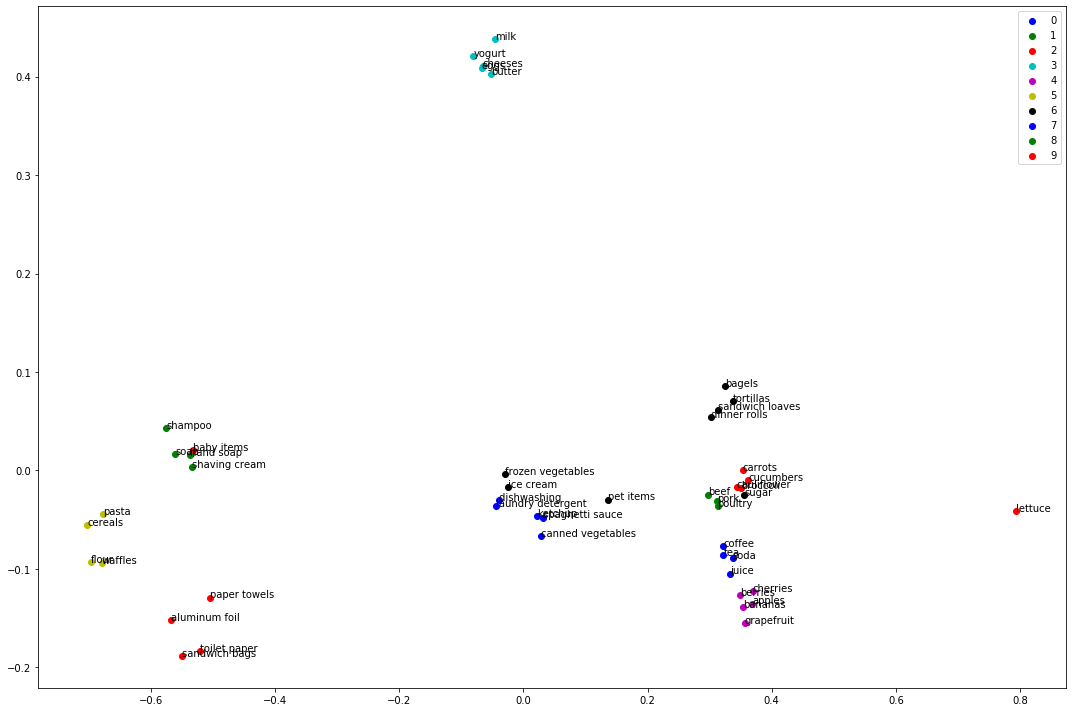

In [0]:
import re
from collections import Counter
import itertools
cluster(n_clusters=10)

**From the above vizualisation we can see that shampoo, soaps, shaving cream has been assigned to 1 single cluster which is amazing. Text mining is so fascinating. Isn't it?**

Thank you